In [1]:
import tensorflow as tf                                        # tensorflow for modelling
import numpy as np                                             # numpy for math computations
import matplotlib.pyplot as plt                                # visualizations
import sklearn                                                 # scikit-learn
import cv2                                                     # image processing
from sklearn.metrics import confusion_matrix, roc_curve        # metrics
import seaborn as sns                                          # visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector
BATCH_SIZE=64

# Data Preparation

In [2]:
# Download dataset and split into train, validation and test set.

train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete22VXFY/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete22VXFY/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete22VXFY/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [4]:
# investigate few sample of validation set.
# Here in dataset, label 0= negative review & 1=positve review.

for review,label in val_ds.take(5):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [5]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)                                             # text will be lowercased.
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")                            # regex expression for removing html tags.
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")    # all punctuation removed.

    return output

In [6]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [7]:
# Tensorflow text Vectorization
# Here, arguments -
# max_tokens describes the maximum size of the vocabulary for this layer.
# standardize, whose role is literally to standardize the inputs text, where we could pass customize function, which should do standardization process.
# So we will be using our own function.
# output_sequence_length, signifies the maximum length of our different sentences.

vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [8]:
# construct training data
training_data=train_ds.map(lambda x,y:x)  # input x and y and outputx

# create our vocabulary using tensorflow adapt method on our training_data set.
vectorize_layer.adapt(training_data)      # adapt the vectorize_layer to the training data

In [9]:
# vocabulary list
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'this',
 'i',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'are',
 'you',
 'his',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'like',
 'so',
 'her',
 'or',
 'just',
 'about',
 'has',
 'out',
 'if',
 'some',
 'what',
 'there',
 'good',
 'more',
 'very',
 'when',
 'she',
 'even',
 'up',
 'no',
 'would',
 'my',
 'which',
 'only',
 'time',
 'really',
 'story',
 'their',
 'were',
 'had',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'been',
 'get',
 'well',
 'will',
 'into',
 'because',
 'people',
 'other',
 'also',
 'do',
 'bad',
 'great',
 'how',
 'first',
 'most',
 'him',
 'dont',
 'made',
 'movies',
 'then',
 'films',
 'make',
 'could',
 'way',
 'them',
 'any',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'two',
 'many',
 'being',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'plot',
 'where',
 'best',
 '

In [10]:
# now we would like to check vectorized version of review & label, by passing it inot our vectorize_layer,
# which has been adapted on our full dataset, we will be able to convert this into numbers.

def vectorizer(review,label):
    return vectorize_layer(review),label

In [11]:
# mapp dataset onto all, which is now vectorized.
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [12]:
# check vectorized train_dataset
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [13]:
# Prefetching for more efficient loading of data.

train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Modeling

# Conv1D

In [14]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    # Here, model have 32 filter size & kernel size of 3
    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 248, 32)           28832     
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense (Dense)               (None, 32)                253984    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
Non-

In [15]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 72s 183ms/step - loss: 0.6912 - accuracy: 0.5207 - val_loss: 0.6827 - val_accuracy: 0.5724
Epoch 2/10
391/391 [==============================] - 61s 157ms/step - loss: 0.5197 - accuracy: 0.7538 - val_loss: 0.3551 - val_accuracy: 0.8546
Epoch 3/10
391/391 [==============================] - 58s 149ms/step - loss: 0.2972 - accuracy: 0.8868 - val_loss: 0.3088 - val_accuracy: 0.8686
Epoch 4/10
391/391 [==============================] - 62s 160ms/step - loss: 0.2237 - accuracy: 0.9186 - val_loss: 0.3184 - val_accuracy: 0.8666
Epoch 5/10
391/391 [==============================] - 57s 145ms/step - loss: 0.1839 - accuracy: 0.9400 - val_loss: 0.3345 - val_accuracy: 0.8628
Epoch 6/10
391/391 [==============================] - 56s 144ms/step - loss: 0.1511 - accuracy: 0.9530 - val_loss: 0.3694 - val_accuracy: 0.8572
Epoch 7/10
391/391 [==============================] - 58s 147ms/step - loss: 0.1231 - accuracy: 0.9646 - val_loss: 0.4010 - val_ac

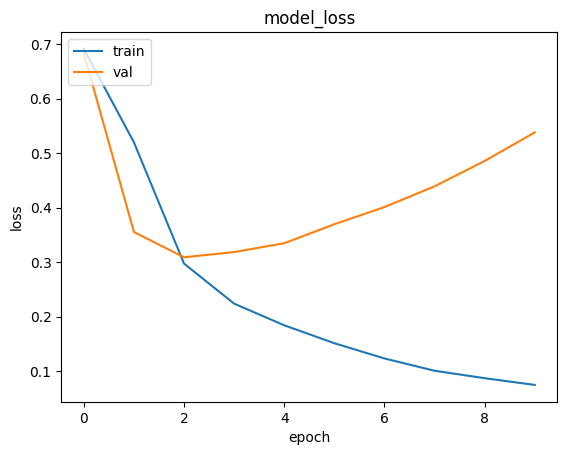

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

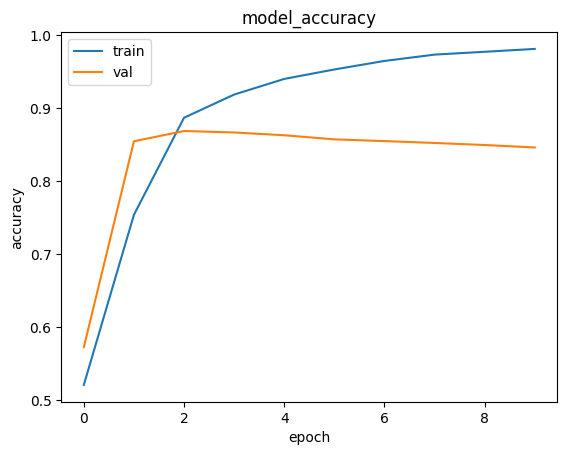

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

In [20]:
model.load_weights(checkpoint_filepath)

In [21]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 7s 35ms/step - loss: 0.3124 - accuracy: 0.8675


[0.3123705983161926, 0.8675199747085571]

The evaluation shows that, the best performing model for this IMDB reviews dataset is Conv1D. The results exibits moodel final output 86.75% accuracy, and the best validation accuracy we had %86.86 at 3rd epoch. This happens to be better than GRU, RNN and LSTM.